In [9]:
from pathlib import Path
import os
print(os.getcwd())

from pathlib import Path
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from typing import List
import os, re

# Fixed dB window used when you generated the cache.
# If you used librosa.power_to_db(S, ref=np.max), values are usually in [-80, 0].
DB_MIN, DB_MAX = -80.0, 0.0

# # Tiling choice for the two channels: "v" (vertical stack) or "h" (horizontal concat)
# TILE = "v"

# Reproducibility
random.seed(1337)
np.random.seed(1337)

/Users/hughsignoriello/Developer/ML-based-analysis-of-sound


In [10]:
from src.utils.utils import CLASSES, decode_label_bits, load_npy


def db_to_uint8(img_db: np.ndarray, db_min: float, db_max: float) -> np.ndarray:
    """Map dB image to uint8 [0,255] with fixed range for consistent appearance."""
    x = np.clip(img_db, db_min, db_max)
    x = (x - db_min) / (db_max - db_min + 1e-12)
    return (x * 255.0).round().astype(np.uint8)

def choose_one_per_class(df: pd.DataFrame) -> pd.DataFrame:
    # sample one row per label (deterministic by sorting)
    picked = []
    for label, grp in sorted(df.groupby("label"), key=lambda x: x[0]):
        picked.append(grp.sample(n=1, random_state=1337).iloc[0])
    return pd.DataFrame(picked).reset_index(drop=True)

def make_display_image(mel_2c: np.ndarray, tile: str = "v") -> np.ndarray:
    """Return a 2D uint8 image from a (2, F, T) mel tensor."""
    assert mel_2c.ndim == 3 and mel_2c.shape[0] == 2, "Expected (2, F, T)"
    left_u8 = db_to_uint8(mel_2c[0], DB_MIN, DB_MAX)
    right_u8 = db_to_uint8(mel_2c[1], DB_MIN, DB_MAX)
    if tile == "h":
        return np.concatenate([left_u8, right_u8], axis=1)
    return np.concatenate([left_u8, right_u8], axis=0)

def load_manifest(manifest_csv: str) -> pd.DataFrame:
    """
    Load a manifest CSV with consistent label handling.
    
    - Preserves leading zeros in label_multi.
    - Normalizes label_multi to exactly len(CLASSES) bits.
    - If a 'label' column exists, keeps it stringified.
    - Adds a human-readable decoded label column.
    """
    df = pd.read_csv(
        manifest_csv,
        dtype={"label_multi": "string"},  # keep leading zeros
        keep_default_na=False             # don't interpret "000..." as NaN
    )

    # If plain 'label' column exists, normalize it
    if "label" in df.columns:
        df["label"] = df["label"].astype(str).str.strip().str.lower()

    # Clean and normalize label_multi to match CLASSES length
    if "label_multi" in df.columns:
        df["label_multi"] = (
            df["label_multi"].astype("string")
            .str.strip()
            .str.lower()
            .str.replace(r"[^01]", "", regex=True)
            .str.pad(len(CLASSES), side="right", fillchar="0")
            .str[:len(CLASSES)]
        )
        # Add decoded labels for convenience
        df["label"] = df["label_multi"].apply(lambda s: decode_label_bits(s, CLASSES))

    return df

# ---- Plotting ----
def plot_first_n_mels(manifest_csv: str, n: int = 5, tile: str = "v") -> None:
    df = load_manifest(manifest_csv)

    # Take first n rows that actually exist on disk (robust to stale manifest)
    rows = []
    for _, r in df.iterrows():
        if os.path.exists(r["filepath"]):
            rows.append(r)
            if len(rows) >= n:
                break
    if not rows:
        print("No files found on disk matching manifest filepaths. Check MANIFEST_CSV and paths.")
        return

    for i, r in enumerate(rows, 1):
        mel = load_npy(r["filepath"])   # expects shape (2, F, T)
        img = make_display_image(mel, tile=tile)

        plt.figure(figsize=(10, 5))
        plt.imshow(img, aspect="auto", origin="lower")
        plt.title(f"{r.get('irmas_filename', Path(r['filepath']).name)} — {r['label']}")
        plt.xlabel("Frames")
        plt.ylabel("Mel bins (stacked L/R)")
        plt.tight_layout()
        plt.show()




# IRMAS Train Mels

Found 11 classes: ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
mel shape: (2, 128, 301)
cel
                                            filepath label
0  .cache/mels/irmas/train/cel/032__[cel][nod][cl...   cel
1  .cache/mels/irmas/train/cla/[cla][pop_roc]0296...   cla
2  .cache/mels/irmas/train/flu/[flu][pop_roc]0379...   flu
3  .cache/mels/irmas/train/gac/[gac][pop_roc]0684...   gac
4  .cache/mels/irmas/train/gel/192__[gel][dru][co...   gel


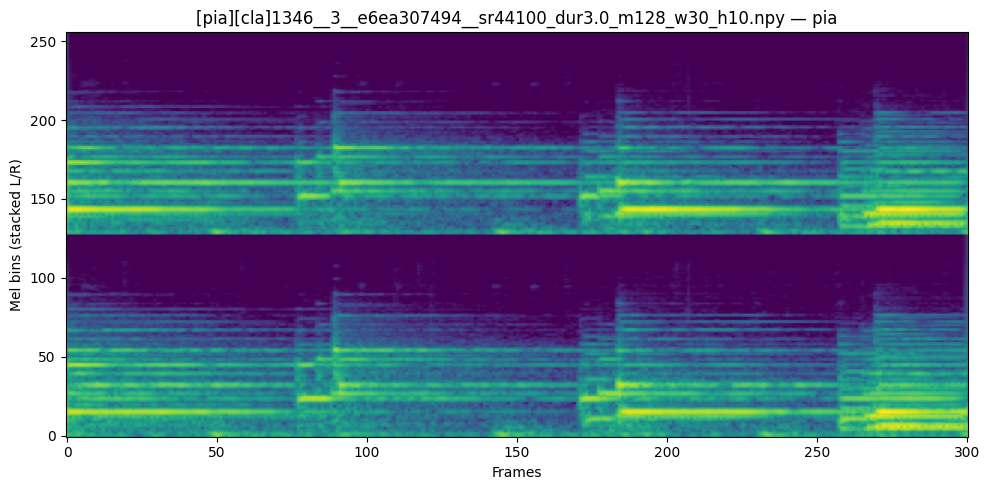

In [11]:


TRAIN_MEL_MANIFEST = "data/manifests/irmas_train_mels.csv" # update accordingly
N_TO_SHOW = 1
df = load_manifest(TRAIN_MEL_MANIFEST)
classes = sorted(df["label"].unique())   # should be 11 IRMAS classes
print(f"Found {len(classes)} classes:", classes)
samples_df_train = choose_one_per_class(df)
path = samples_df_train.iloc[1]['filepath']
mel = load_npy(path) 
print("mel shape:", mel.shape)
print(samples_df_train.iloc[0]['label'])
print(samples_df_train.head())
plot_first_n_mels(TRAIN_MEL_MANIFEST, n=N_TO_SHOW, tile="v")


# IRMAS Test Mels

mel shape: (2, 128, 301)
Loaded 4958 test windows
                                            filepath  label_multi  \
0  .cache/mels/irmas/test/(02) dont kill the whal...      1000000   
1  .cache/mels/irmas/test/(02) dont kill the whal...      1000000   
2  .cache/mels/irmas/test/(02) dont kill the whal...      1000000   
3  .cache/mels/irmas/test/(02) dont kill the whal...      1000000   
4  .cache/mels/irmas/test/(02) dont kill the whal...      1000000   

                   irmas_filename  start_ms  
0  (02) dont kill the whale-1.wav         0  
1  (02) dont kill the whale-1.wav      3000  
2  (02) dont kill the whale-1.wav      6000  
3  (02) dont kill the whale-1.wav      9000  
4  (02) dont kill the whale-1.wav     12000  


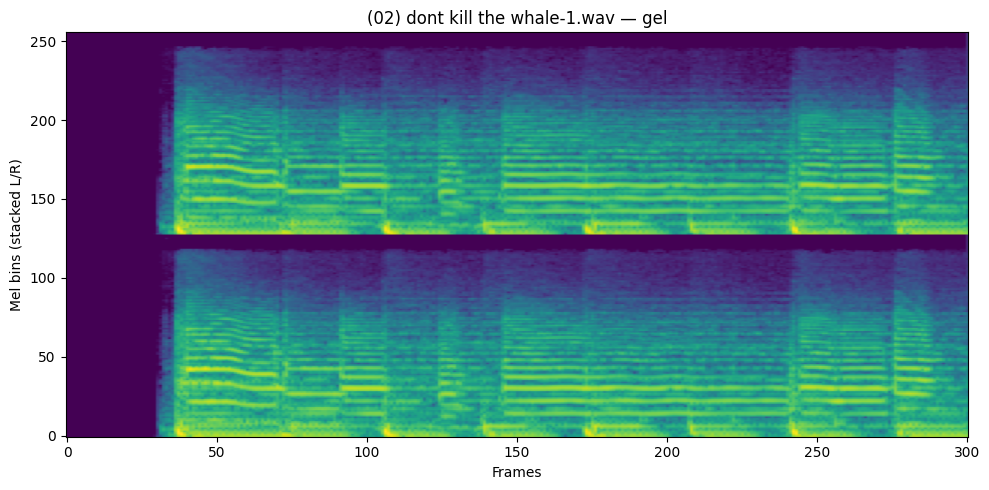

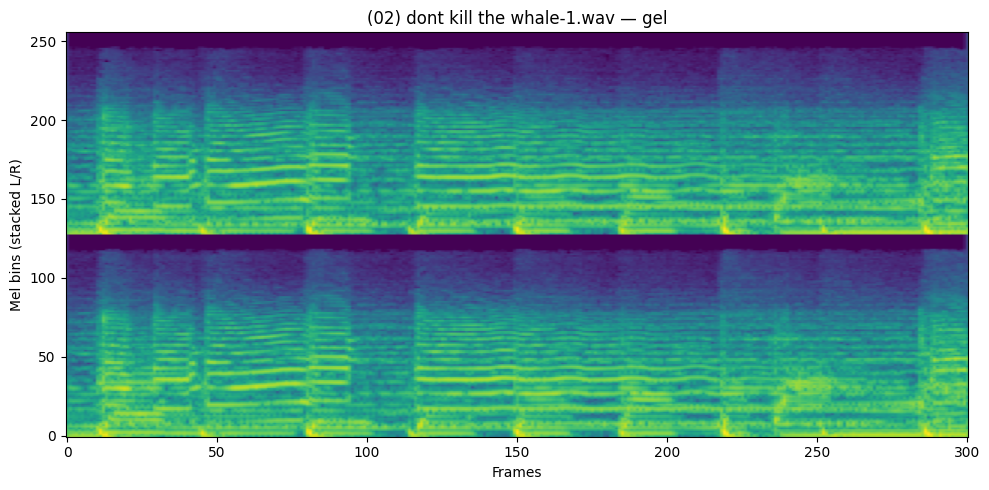

In [12]:

TEST_MEL_MANIFEST = Path("data/manifests/irmas_test_mels.csv")
N_TO_SHOW = 2
test_df = pd.read_csv(TEST_MEL_MANIFEST)
test_df = test_df.reset_index(drop=True)

path = test_df.iloc[1]['filepath']
mel = load_npy(path) 
print("mel shape:", mel.shape)

print(f"Loaded {len(test_df)} test windows")
print(test_df.head())
plot_first_n_mels(TEST_MEL_MANIFEST, n=N_TO_SHOW, tile="v")

# Other Code
## Plot and Compare

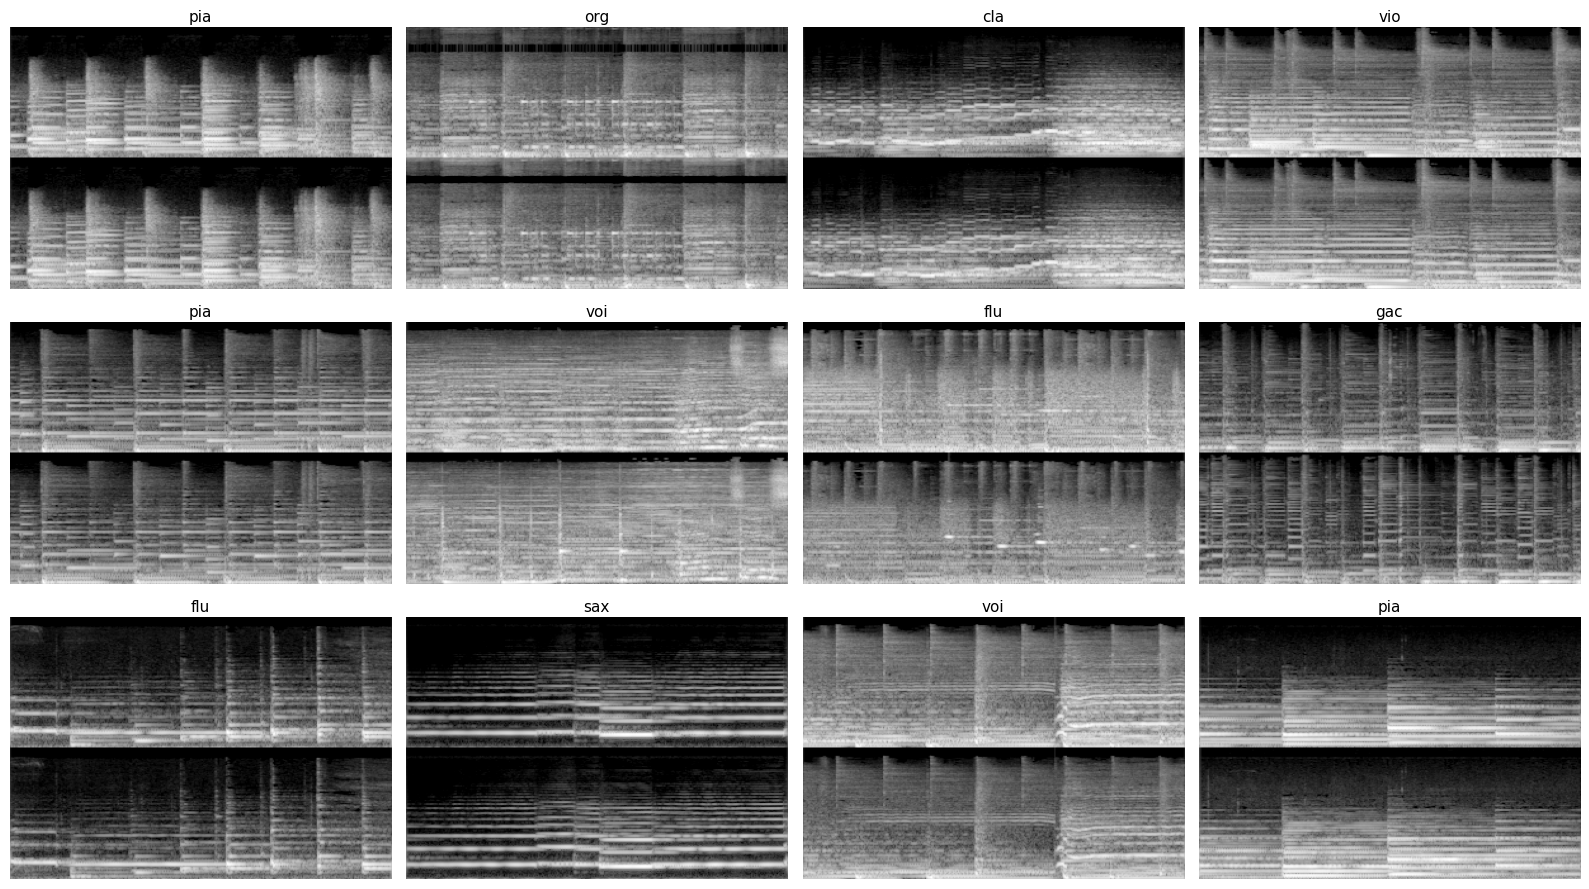

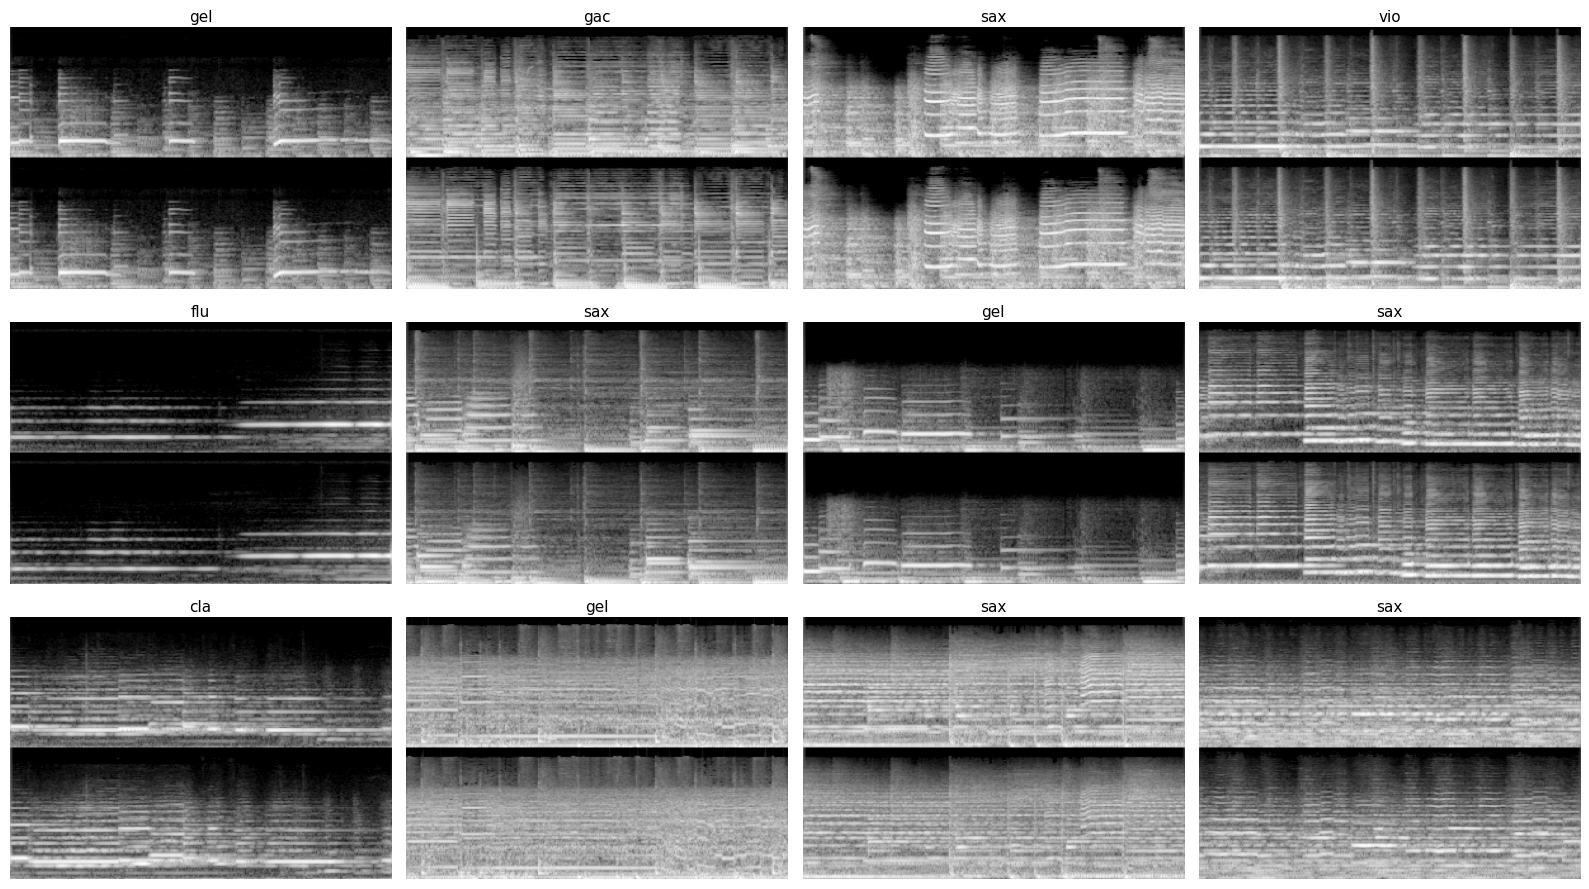

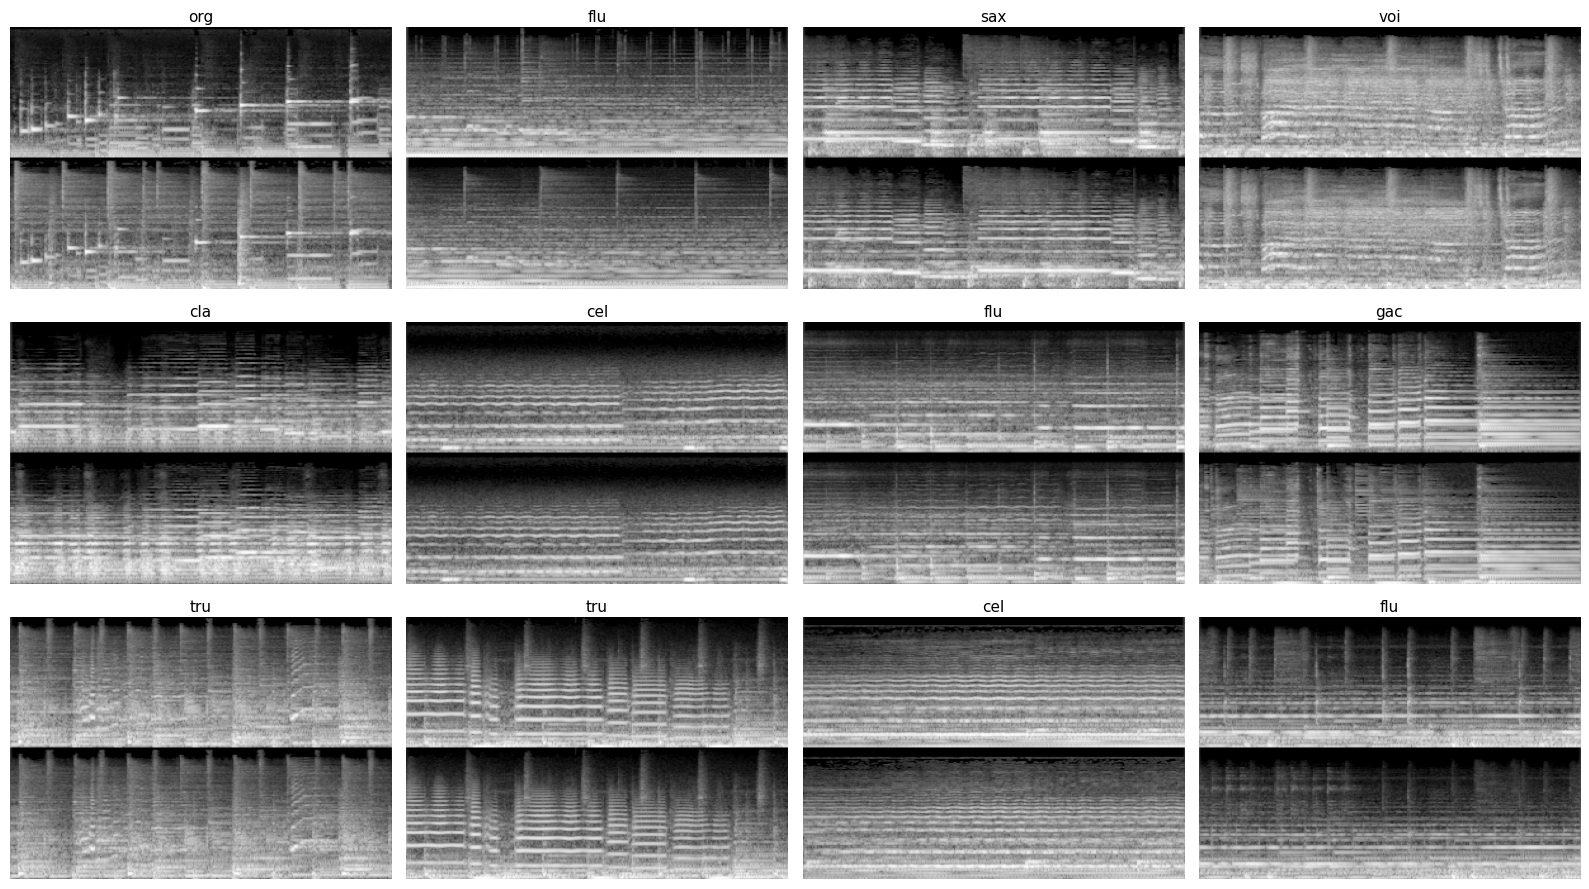

In [13]:
def plot_sample_grid(samples_df, tile_mode="h", sample_idx=None, cols=4):
    """Plot a grid of mel spectrogram previews for the specified rows."""
    TILE = tile_mode  # preserves existing helper behaviour

    if sample_idx is None:
        subset = samples_df
    else:
        subset = samples_df.iloc[sample_idx]

    N = len(subset)
    COLS = cols
    ROWS = math.ceil(N / COLS)

    fig_h_per_row = 3.0 if TILE == "v" else 2.2
    fig_w = 16
    fig_h = fig_h_per_row * ROWS

    fig, axes = plt.subplots(ROWS, COLS, figsize=(fig_w, fig_h))
    axes = np.atleast_2d(axes)

    for i in range(ROWS * COLS):
        r, c = divmod(i, COLS)
        ax = axes[r, c]
        ax.axis("off")
        if i >= N:
            continue

        row = subset.iloc[i]
        mel = load_npy(row["filepath"])
        img = make_display_image(mel, TILE)
        ax.imshow(img[::-1, :], aspect="auto", cmap="gray")
        ax.set_title(row["label"], fontsize=11, pad=4)

    plt.tight_layout()
    plt.show()

N_TRAIN_DISPLAY = min(12, len(df))
train_shuffled = df.sample(frac=1, random_state=0).reset_index(drop=True)

train_view_1 = train_shuffled.iloc[:N_TRAIN_DISPLAY]
if not train_view_1.empty:
    plot_sample_grid(train_view_1.reset_index(drop=True), tile_mode="v")

train_view_2 = train_shuffled.iloc[N_TRAIN_DISPLAY:2 * N_TRAIN_DISPLAY]
if not train_view_2.empty:
    plot_sample_grid(train_view_2.reset_index(drop=True), tile_mode="v")

train_view_3 = train_shuffled.iloc[2 * N_TRAIN_DISPLAY:3 * N_TRAIN_DISPLAY]
if not train_view_3.empty:
    plot_sample_grid(train_view_3.reset_index(drop=True), tile_mode="v")
